Hi, I want to share my experiments with you, I hope it will be useful. <br>
In my solution (8th place) I used fasttext

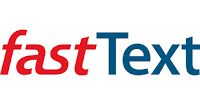
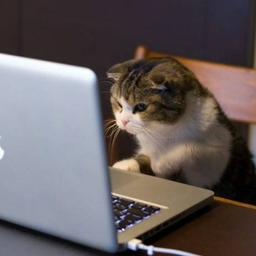

In [2]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

!pip install pymorphy2
import re
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from nltk.corpus import stopwords

from multiprocessing import Pool
from tqdm import tqdm

import nltk
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from tqdm.auto import tqdm
import torch
# import torch.nn as nn
# import torch.optim as optim
# from transformers import DistilBertTokenizer, DistilBertModel

np.random.seed(42)
random.seed(42)

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 455.9 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 13.2 MB/s eta 0:00:0000:0100:01


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Save train/test dataset and take a look at some train data

In [3]:
test = pd.read_csv('../input/hse-nlp-bootcamp-dl-track/new_test_dl.csv')
test = test.drop('Unnamed: 0', axis=1)
train = pd.read_csv('../input/hse-nlp-bootcamp-dl-track/train_dl.csv')
train

,bank,feeds,grades,date
0,unicreditbank,Я очень редко пользуюсь банковскими продуктами...,5.0,31.12.2017 18:20
1,fk_otkritie,Я вместе с женой 15.11.2019 обратился в отделе...,1.0,22.11.2019 22:42
2,alfabank,Добрый день.Сегодня 27.12.2018 г около 15.40-1...,1.0,27.12.2018 23:20
3,vtb,"""Где карточку открывали, туда и идите..."" - эт...",2.0,05.02.2020 16:40
4,promsvyazbank,При покупках в iTunes списываются завышенные с...,NaN,26.02.2016 15:48
...,...,...,...,...
349995,investtorgbank,Хочу поделиться своим положительными опытом от...,5.0,17.12.2012 22:57
349996,unicreditbank,Добрый день!Хочу оставить отзыв по банку Юникр...,1.0,01.02.2021 11:44
349997,locko-bank,Доброго дня! Обратился в Локо Банк с просьбой ...,5.0,24.04.2020 11:39
349998,tcs,"Просрочил платеж на 5 дней, а мне уже взыскани...",NaN,24.11.2020 23:39


### Analyse data

We found out that there is some NaN at 'grades' column<br>
Let's see the information

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350000 entries, 0 to 349999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   bank    350000 non-null  object 
 1   feeds   350000 non-null  object 
 2   grades  240250 non-null  float64
 3   date    350000 non-null  object 
dtypes: float64(1), object(3)
memory usage: 10.7+ MB


Convert the column with the timestamp to the appropriate format. Delete rows with skips in the target

In [5]:
train['date'] = pd.to_datetime(train['date'], format='%d.%m.%Y %H:%M')
train = train.dropna()
train = train.astype({'grades': 'int32'})
train.sample(5)

,bank,feeds,grades,date
70106,bcs-bank,Уважаемый банк БКС! С первых дней обслуживания...,1,2021-01-31 01:10:00
293909,sberbank,Ситуация на текущий момент 08.02.15. 21.00.С м...,1,2015-02-08 21:03:00
295466,mkb,В конце июля я уже писала по поводу навязывани...,1,2016-09-07 21:10:00
277828,vtb,"Сегодня в 11:43 мне позвонил сотрудник КЦ, кот...",1,2020-04-02 21:12:00
221435,alfabank,Добрый день.В августе оформил себе карту Alfa-...,1,2019-01-29 05:55:00


In [6]:
feeds_by_bank_count = train.bank.value_counts()
feeds_by_bank_count

sberbank            38894
vtb                 25336
tcs                 20850
sovcombank          12273
fk_otkritie         12254
                    ...  
baltinvestbank        159
metallinvestbank      157
bystrobank            145
rnbank                133
primsotsbank          123
Name: bank, Length: 69, dtype: int64

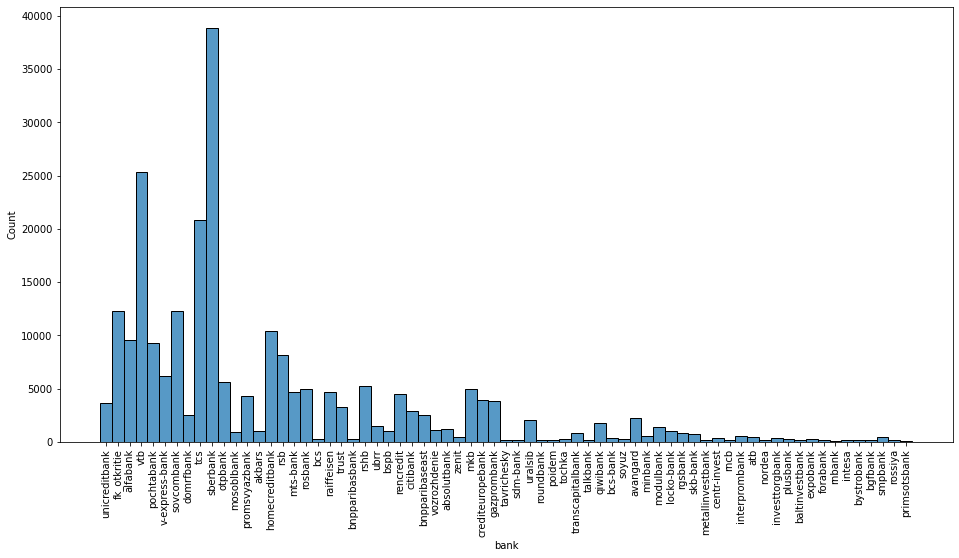

In [7]:
plt.figure(figsize=(16,8))
sns.histplot(data=train.sort_values(by='bank'), 
             x=train.bank)
plt.xticks(rotation=90)
plt.show()

Distribution of client ratings:

In [8]:
train.grades.value_counts().sort_index()

1    129814
2     25803
3     11131
4      7094
5     66408
Name: grades, dtype: int64

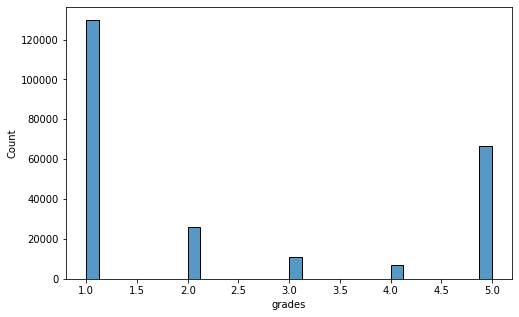

In [9]:
plt.figure(figsize=(8, 5))
sns.histplot(data=train, 
             x=train.grades, )
plt.show()

Length of review:

In [10]:
train['sym_len'] = train.feeds.apply(len)
train['word_len'] = train.feeds.apply(lambda x: len(x.split()))

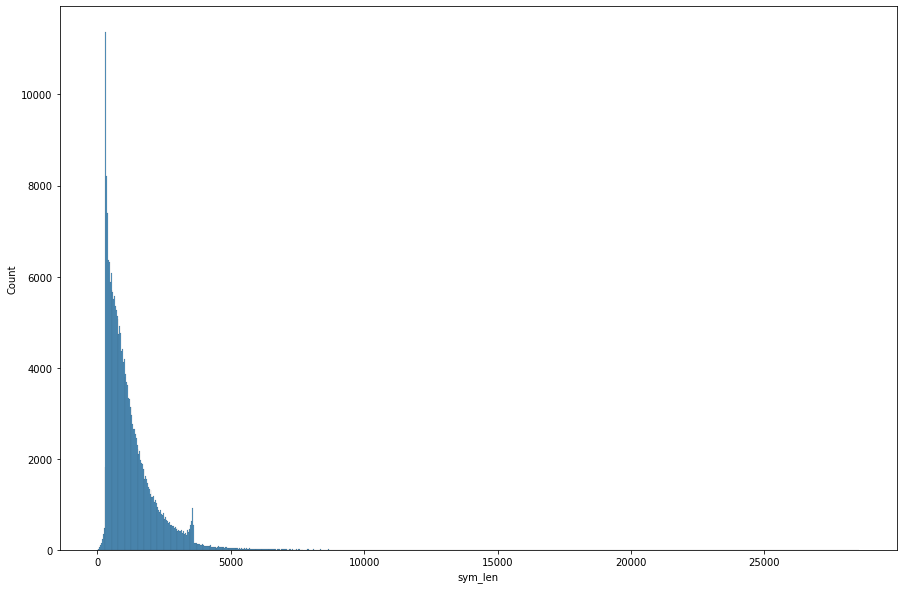

In [11]:
plt.figure(figsize=(15, 10))
sns.histplot(data=train.sym_len)
plt.show()

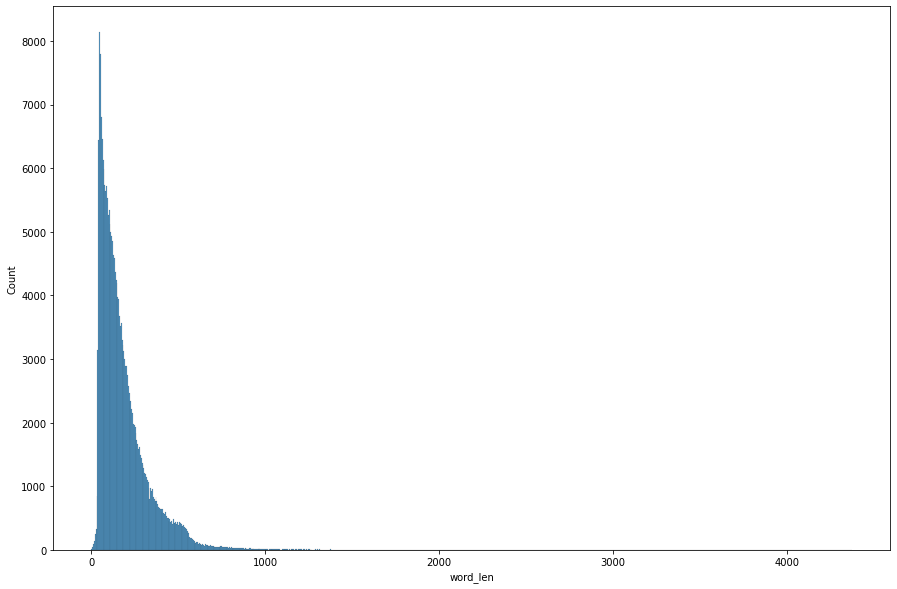

In [12]:
plt.figure(figsize=(15, 10))
sns.histplot(data=train.word_len)
plt.show()

### Write clean text function

In [13]:
m = MorphAnalyzer()
regex = re.compile("[А-Яа-яA-z]+")

def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

@lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]


mystopwords = stopwords.words('russian') 
def remove_stopwords(lemmas, stopwords = mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)
    
    return ' '.join(remove_stopwords(lemmas))

### Do lemmatisation and clean data

I have done lemmatization of this dataset, so we will upload a csv file

In [14]:
new_train = pd.read_csv('../input/lemmas-new-train/new_train.csv')
new_train = new_train.drop('Unnamed: 0', axis=1)
new_train

,lemmas
0,очень редко пользоваться банковский продукт не...
1,вместе жена обратиться отделение банк открытие...
2,добрый день сегодня около банкомат адрес рязан...
3,карточка открывать туда идти фраза давно стать...
4,оформить кредит наличные отделение почта банк ...
...,...
240245,являться зарплатник сбербанк поэтому выбор бан...
240246,открывать первый расчётный счёт различный банк...
240247,хотеть поделиться свой положительный опыт полу...
240248,добрый день хотеть оставить отзыв банк юникред...


Add name of bank to our lemmas

In [15]:
train = train.reset_index()
# new_train = new_train.reset_index()

for i in range(len(new_train['lemmas'])):
    new_train['lemmas'][i] = train['bank'][i] + ' ' + new_train['lemmas'][i]
#     print(new_train['lemmas'][i])
new_train.sample(5)

,lemmas
235695,fk_otkritie выражать благодарность специалист ...
100019,v-express-bank банк выбирать навязать покупка ...
129727,sovcombank пользователь халва халява обещать б...
196881,vtb здравствуйте открытие брокерский счёт реши...
25458,rosbank хотеть поблагодарить менеджер анастаси...


For train  lemmatization, uncomment this code

In [16]:
# with Pool(4) as p:
#     lemmas = list(tqdm(p.imap(clean_text, train['feeds']), total=len(train)))
    
# train['lemmas'] = lemmas
# train.sample(5)

I was also thinking how to solve the class disbalance problem
I found the ratio of the number of rows of a larger class to a smaller one, and supplemented the dataset to the number of a large class by copying lemmas. However, this led to a deterioration of the score

In [17]:
# отношение количества строк с (i+1) к 1 Approved
# const_1 = len(train.loc[train['grades']==1])
# def ratioOfNumOfRows(i):
#     const_i = len(train.loc[train['grades']==i])
#     rat = const_1//const_i
#     print(f'for class{i} = {rat}')
#     df_i = train.loc[train['grades']==i]
#     if (rat != 1):
#         df_i = df_i.loc[df_i.index.repeat(rat)]
#     else:
#         df_i = df_i.loc[df_i.index.repeat(2)]
# #     train_n = pd.concat([train.loc[train['grades']==1], df_i]).sample(frac=1)
# #     print(train_n)
#     return df_i

In [18]:
# train_n = train.loc[train['grades']==1]
# print(train_n.grades.value_counts())
# for i in range(5):
#     if (i != 0):
#         train_i = ratioOfNumOfRows(i+1)
#         train_n = pd.concat([train_n, train_i]).sample(frac=1)

Save y_train and free RAM for more experiment

In [19]:
# y_train = train_n.grades
# y_train = y_train.reset_index().drop(columns='index')
# lemmas = train_n['lemmas']
# del train, train_n

y_train = train.grades
y_train = y_train.reset_index().drop(columns='index')
del train

Lemmatization for a test dataset

In [20]:
with Pool(4) as p:
    lemmas_test = list(tqdm(p.imap(clean_text, test['feeds']), total=len(test)))

  0%|          | 0/34114 [00:00<?, ?it/s]

In [21]:
test = test.reset_index()
for i in range(len(lemmas_test)):
    lemmas_test[i] = test['bank'][i] + ' ' + lemmas_test[i]

I also had an idea to get rid of the class imbalance by reducing the dataset to the number of the selected class.<br> However, this led to a deterioration of the score

In [22]:
# class_1,class_2,class_3,class_4,class_5 = train.grades.value_counts().sort_index()
# train.grades.value_counts().sort_index()

In [23]:
# c5 = train[train['grades'] == 5]
# c4 = train[train['grades'] == 4]
# c3 = train[train['grades'] == 3]
# c2 = train[train['grades'] == 2]
# c1 = train[train['grades'] == 1]

# df_5 = c5.sample(class_4)
# df_3 = c3.sample(class_4)
# df_2 = c2.sample(class_4)
# df_1 = c1.sample(class_4)

In [24]:
# undersampled_df = pd.concat([df_1,df_2,df_3,c4,df_5],axis=0)

In [25]:
# undersampled_df = undersampled_df.sample(frac=1)

In [26]:
# undersampled_df.grades.value_counts()

In [27]:
# new_train = pd.DataFrame(lemmas, columns=['lemmas'])
# new_train

Save train dataset with lemmas

In [28]:
new_test = pd.DataFrame(lemmas_test, columns=['lemmas'])

### Fast Text model

In [29]:
import fasttext

with open('ft_train_data1.txt', 'w') as f:
    for pair in list(zip(new_train['lemmas'], y_train['grades'])):
        text, label = pair
        f.write(f'__label__{label} {text.lower()}\n')
        
with open('ft_test_data1.txt', 'w') as f:
        text = new_test['lemmas']
        f.write(f'{text.str.lower()}\n')

Print some data

In [30]:
! head -n 3 ft_train_data1.txt

__label__5 unicreditbank очень редко пользоваться банковский продукт необходимость кредит возникнуть юникредит банк обслуживаться близкий родственник проблема выбор офис прийти рекомендация константин толмачёв очень быстро заполнить заявка нужно день лететь питер сойтись одобрить деньга получить константин также выпустить бесплатный карта который должный получить петербург сожаление приша отказ карта успеть забрать поэтому константин переслать карта поздний закрыть понадобиться либо банковский продукт знать обратиться рекомендация личный опыт качественный обслуживание личный опыт
__label__1 fk_otkritie вместе жена обратиться отделение банк открытие находиться адрес санкт петербург ленинский проспект далее лита цель оформление заявка рефинансирование ипотечный кредит сотрудник банк жена предоставить необходимый справка документ сотрудник банк снять копия скан перечисленный выше документ поставить дата печать банк свой подпись внести информационный система банк положить конверт отправка 

In [38]:
fasttext_params = {
    'input': 'ft_train_data1.txt',
    'lr': 0.1,
    'lrUpdateRate': 1000,
    'thread': 8,
    'epoch': 10,
    'wordNgrams': 3,
    'dim': 100,
    'loss': 'softmax'
}
classifier = fasttext.train_supervised(**fasttext_params)

# classifier = fasttext.train_supervised('ft_train_data1.txt')#, 'model')
result = classifier.test('ft_test_data1.txt')
print('P@1:', result[1])#.precision)
print('R@1:', result[2])#.recall)
print('Number of examples:', result[0])#.nexamples)

Read 26M words
Number of words:  143769
Number of labels: 5
Progress:  99.9% words/sec/thread:  250488 lr:  0.000124 avg.loss:  0.421561 ETA:   0h 0m 0s

P@1: nan
R@1: nan
Number of examples: 0


Progress: 100.0% words/sec/thread:  250414 lr:  0.000000 avg.loss:  0.421297 ETA:   0h 0m 0s


Let's make predictions

In [39]:
pred = classifier.predict(lemmas_test)[0]
pred[:10]

[['__label__1'],
 ['__label__1'],
 ['__label__5'],
 ['__label__1'],
 ['__label__1'],
 ['__label__1'],
 ['__label__1'],
 ['__label__1'],
 ['__label__5'],
 ['__label__5']]

In [40]:
pred = [label[0].split('__')[-1] for label in pred]
pred[:10]

['1', '1', '5', '1', '1', '1', '1', '1', '5', '5']

### Save results

In [41]:
sol = pd.DataFrame({'inds': test.index,
                    'grades': pred})
sol

,inds,grades
0,0,1
1,1,1
2,2,5
3,3,1
4,4,1
...,...,...
34109,34109,1
34110,34110,1
34111,34111,1
34112,34112,1


In [42]:
sol.grades.value_counts()

1    22021
5     9945
2     1648
4      262
3      238
Name: grades, dtype: int64

In [35]:
sol.to_csv('submit.csv', index=False)